## Case Study

Today we are going to use all the skills we have learned to tackle a real
problem in industry. The problem is churn prediction with a ride-sharing
company in San Francisco.  Since the data is sourced from a real company, we
ask you not to share the dataset. See more about the problem in
[group.md](group.md). 


## Notes

The `churn_train.csv` and `churn_test.csv` files are an 80:20 train-test-split of the `churn.csv` data.  For some friendly competition, students should only use the `churn_train.csv` file for model and hyperparameter selection, and then at the end of the day see how they do on the unseen `churn_test.csv.`

Honor code, people!


## Case Study - Churn Prediction

A ride-sharing company (Company X) is interested in predicting rider retention.
To help explore this question, we have provided a sample dataset of a cohort of
users who signed up for an account in January 2014. The data was pulled on July
1, 2014; we consider a user retained if they were “active” (i.e. took a trip)
in the preceding 30 days (from the day the data was pulled). In other words, a
user is "active" if they have taken a trip since June 1, 2014. The data,
`churn.csv`, is in the [data](data) folder.  The data are split into train and
test sets.  You are encouraged to tune and estimate your model's performance on
the train set, then see how it does on the unseen data in the test set at the
end.

We would like you to use this data set to help understand **what factors are
the best predictors for retention**, and offer suggestions to help Company X. 
Therefore, your task is not only to build a
model that minimizes error, but also a model that allows you to interpret the
factors that contributed to your predictions.

Here is a detailed description of the data:

- `city`: city this user signed up in phone: primary device for this user
- `signup_date`: date of account registration; in the form `YYYYMMDD`
- `last_trip_date`: the last time this user completed a trip; in the form `YYYYMMDD`
- `avg_dist`: the average distance (in miles) per trip taken in the first 30 days after signup
- `avg_rating_by_driver`: the rider’s average rating over all of their trips 
- `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips 
- `surge_pct`: the percent of trips taken with surge multiplier > 1 
- `avg_surge`: The average surge multiplier over all of this user’s trips 
- `trips_in_first_30_days`: the number of trips this user took in the first 30 days after signing up 
- `luxury_car_user`: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise 
- `weekday_pct`: the percent of the user’s trips occurring during a weekday


## Work Flow

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the
provided data for this analysis.
   
2. Build a predictive model to help determine the probability that a rider will
be retained.

3. Evaluate the model.  Focus on metrics that are important for your *statistical
model*.
 
4. Identify / interpret features that are the most influential in affecting
your predictions.

5. Discuss the validity of your model. Issues such as
leakage.  For more on leakage, see [this essay on
Kaggle](https://www.kaggle.com/dansbecker/data-leakage), and this paper: [Leakage in Data
Mining: Formulation, Detection, and Avoidance](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.365.7769&rep=rep1&type=pdf).

6. Repeat 2 - 5 until you have a satisfactory model.

7. Consider business decisions that your model may indicate are appropriate.
Evaluate possible decisions with metrics that are appropriate for *decision
rules*.
   
## Deliverables

- Code you used to build the model.  The more repeatable, self explanatory, the
  better.

- A presentation including the following points:
  - How did you compute the target?
  - What model did you use in the end? Why?
  - Alternative models you considered? Why are they not good enough?
  - What performance metric did you use to evaluate the *model*? Why?
  - **Based on insights from the model, what plans do you propose to
    reduce churn?**
  - What are the potential impacts of implementing these plans or decisions?
    What performance metrics did you use to evaluate these *decisions*, why?


In [25]:
# import block
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import make_classification
import sklearn
import itertools

# James' import block - contains data processing encoders.
#from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
#from fancyimpute import KNN

In [37]:
# parameters block
plt.style.use("ggplot")
%matplotlib inline

# Set ipython's max row display
pd.set_option('display.max_row', 10000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

plt.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                    'xtick.color' : "white",
                    'ytick.color' : "white"})

In [4]:
# Dataframe declaration block
cdf = pd.read_csv("../data/churn.csv")
ctrdf = pd.read_csv("../data/churn_train.csv")
ctsdf = pd.read_csv("../data/churn_test.csv")

# Dataframe Inspection

In [7]:
cdf

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5.63,4.2,5.0,1.00,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0
49996,0.00,4.0,NaN,1.00,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0
49997,3.86,5.0,5.0,1.00,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0
49998,4.58,3.5,3.0,1.00,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0


In [8]:
ctrdf

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2.06,4.8,4.3,1.08,Winterfell,2014-04-02,Android,2014-01-26,9.5,8,False,90.5
39996,2.05,5.0,5.0,1.00,King's Landing,2014-05-09,iPhone,2014-01-08,0.0,2,False,85.7
39997,3.04,5.0,5.0,1.00,Winterfell,2014-06-24,Android,2014-01-04,0.0,3,True,33.3
39998,3.49,4.3,3.3,1.50,Astapor,2014-02-09,iPhone,2014-01-08,40.0,5,False,60.0


In [9]:
ctsdf

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,2.48,5.0,5.0,1.00,Winterfell,2014-01-07,Android,2014-01-06,0.0,2,True,100.0
1,10.81,5.0,5.0,1.00,Winterfell,2014-04-29,iPhone,2014-01-06,0.0,3,True,100.0
2,12.95,5.0,5.0,1.00,Astapor,2014-01-29,Android,2014-01-19,0.0,1,True,100.0
3,3.92,5.0,NaN,1.00,Winterfell,2014-02-16,iPhone,2014-01-09,0.0,0,False,0.0
4,1.46,5.0,4.5,1.00,Astapor,2014-01-09,iPhone,2014-01-07,0.0,2,False,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.11,5.0,5.0,1.00,King's Landing,2014-02-01,iPhone,2014-01-31,0.0,1,False,100.0
9996,5.49,4.9,4.1,1.00,Winterfell,2014-05-27,iPhone,2014-01-30,0.0,0,True,33.3
9997,2.49,4.2,4.6,1.25,Winterfell,2014-05-24,Android,2014-01-15,18.8,9,True,90.6
9998,1.05,4.0,5.0,1.00,Astapor,2014-01-23,Android,2014-01-22,0.0,1,False,100.0


### Summary Analysis

In [11]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_dist                50000 non-null  float64
 1   avg_rating_by_driver    49799 non-null  float64
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   city                    50000 non-null  object 
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   signup_date             50000 non-null  object 
 8   surge_pct               50000 non-null  float64
 9   trips_in_first_30_days  50000 non-null  int64  
 10  luxury_car_user         50000 non-null  bool   
 11  weekday_pct             50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [28]:
cdf['weekday_pct'].value_counts()

100.0    16659
0.0       9203
50.0      4057
66.7      2088
33.3      1619
         ...  
28.2         1
81.9         1
98.5         1
42.6         1
93.6         1
Name: weekday_pct, Length: 666, dtype: int64

In summary, this dataset is very clean, and there is only NaN values to impute. James worked on imputing these values per column.

In [5]:
churn = cdf

In [8]:
# Block imported from James' notebook. Edited to fit in this noteb oo
#Simple mean impute for ratings columns
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp.fit(churn[['avg_rating_by_driver','avg_rating_of_driver']])
churn_imp = imp.transform(churn[['avg_rating_by_driver','avg_rating_of_driver']])
pd.DataFrame(churn_imp)
churn[['avg_rating_by_driver','avg_rating_of_driver']]=churn_imp
churn

#encode non-null values: https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa 
encoder = OrdinalEncoder()
#imputer = KNN()
cat_cols = ['phone']

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data


for columns in cat_cols:
    encode(churn[columns])

def churn_(df, column):
    dates = df[column]
    cutoff_date = '2014-06-01'
    array = []
    for date in dates:
        if date > cutoff_date:
            array.append(1)
        else:
            array.append(0)
    df['active'] = array
    return df


churn = churn_(churn, 'last_trip_date')


#KNN impute for phone column
imputer = KNNImputer(n_neighbors=5, weights="uniform")
churn_imp2=imputer.fit_transform(churn[['avg_rating_by_driver','avg_rating_of_driver','phone']])
churn[['avg_rating_by_driver','avg_rating_of_driver','phone']]=churn_imp2


# creating instance of one-hot-encoder 
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(churn[['city']]).toarray())
churn = churn.join(enc_df)
churn = churn.drop(['city'],axis =1)

#create feature with difference between signup and last trip
churn['last_trip_date_d'] = pd.to_datetime(churn['last_trip_date'])
churn['signup_date_d'] = pd.to_datetime(churn['signup_date'])
churn['date_delta'] = churn['last_trip_date_d']-churn['signup_date_d']

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:

churn = churn.rename(columns = {0:'city_0', 1:'city_1',2:'city_2'},errors = 'raise')

def date_to_month(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    df['month '+ column_name] = df[column_name].dt.month
    return df

date_to_month(churn, 'signup_date')
churn = churn.drop(['signup_date'],axis =1)
date_to_month(churn, 'last_trip_date')
churn = churn.drop(['last_trip_date'], axis = 1)
churn = churn.drop(['last_trip_date_d','signup_date_d'], axis = 1)

churn['date_delta'] = churn['date_delta'].dt.days

In [17]:
churn.drop(['month signup_date'], axis = 1)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,phone,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,active,city_0,city_1,city_2,date_delta,month last_trip_date
0,3.67,5.0,4.700000,1.10,1.0,15.4,4,True,46.2,1,0.0,1.0,0.0,143,6
1,8.26,5.0,5.000000,1.00,0.0,0.0,0,False,50.0,0,1.0,0.0,0.0,96,5
2,0.77,5.0,4.300000,1.00,1.0,0.0,3,False,100.0,0,1.0,0.0,0.0,1,1
3,2.36,4.9,4.600000,1.14,1.0,20.0,9,True,80.0,1,0.0,1.0,0.0,170,6
4,3.13,4.9,4.400000,1.19,0.0,11.8,14,False,82.4,0,0.0,0.0,1.0,47,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5.63,4.2,5.000000,1.00,1.0,0.0,0,False,100.0,1,0.0,1.0,0.0,131,6
49996,0.00,4.0,4.601559,1.00,1.0,0.0,1,False,0.0,0,1.0,0.0,0.0,1,1
49997,3.86,5.0,5.000000,1.00,0.0,0.0,0,True,100.0,0,0.0,0.0,1.0,111,5
49998,4.58,3.5,3.000000,1.00,1.0,0.0,2,False,100.0,0,1.0,0.0,0.0,1,1


In [40]:
churn2 = churn.drop(labels=['date_delta', 'month last_trip_date'], axis=1, inplace=False, errors='raise')

In [41]:
y = churn2['active']

In [42]:
X = churn2.drop(labels=['active'], axis=1, inplace=False, errors='raise')

In [22]:
X

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,phone,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,city_0,city_1,city_2,date_delta,month signup_date,month last_trip_date
0,3.67,5.0,4.700000,1.10,1.0,15.4,4,True,46.2,0.0,1.0,0.0,143,1,6
1,8.26,5.0,5.000000,1.00,0.0,0.0,0,False,50.0,1.0,0.0,0.0,96,1,5
2,0.77,5.0,4.300000,1.00,1.0,0.0,3,False,100.0,1.0,0.0,0.0,1,1,1
3,2.36,4.9,4.600000,1.14,1.0,20.0,9,True,80.0,0.0,1.0,0.0,170,1,6
4,3.13,4.9,4.400000,1.19,0.0,11.8,14,False,82.4,0.0,0.0,1.0,47,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5.63,4.2,5.000000,1.00,1.0,0.0,0,False,100.0,0.0,1.0,0.0,131,1,6
49996,0.00,4.0,4.601559,1.00,1.0,0.0,1,False,0.0,1.0,0.0,0.0,1,1,1
49997,3.86,5.0,5.000000,1.00,0.0,0.0,0,True,100.0,0.0,0.0,1.0,111,1,5
49998,4.58,3.5,3.000000,1.00,1.0,0.0,2,False,100.0,1.0,0.0,0.0,1,1,1


In [53]:
# Logistic Regression building block
kfold = KFold(n_splits=10)

accuracies = []
precisions = []
recalls = []

X_train, X_test, y_train, y_test = train_test_split(X, y)

for train_index, test_index in kfold.split(X_train):
    model = LogisticRegression(solver="lbfgs", max_iter=100000)
    model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_predict = model.predict(X_train.iloc[test_index]) # Based off training. Try test.
    # y_predict = model.predict(X_test.iloc[test_index])
    y_true = y_train.iloc[test_index]
    # y_true = y_test.iloc[test_index]
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))

print("Accuracy:", np.average(accuracies))
print("Precision:", np.average(precisions))
print("Recall:", np.average(recalls))

Accuracy: 0.7256799999999999
Precision: 0.6683536670330162
Recall: 0.48668726269626433


In [35]:
def roc_curve(probabilities, labels):
#    '''
#    INPUT: numpy array, numpy array
#    OUTPUT: list, list, list

#    Take a numpy array of the predicted probabilities and a numpy array of the
#    true labels.
#    Return the True Positive Rates, False Positive Rates and Thresholds for the
#    ROC curve.
#    '''
    
    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()

def simple_plot(ax, x, y, x_label, y_label, title):
    ax.plot(x, y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

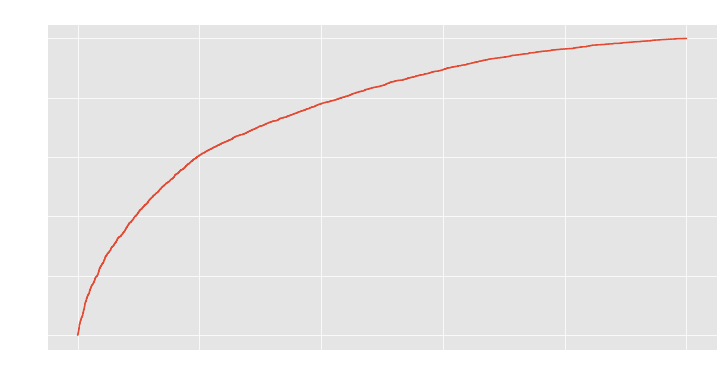

In [54]:
probabilities = model.predict_proba(X_test)[:, 1]
tpr, fpr, thresholds = roc_curve(probabilities, y_test)

fig, ax = plt.subplots(figsize=(12, 6))

simple_plot(ax, fpr, tpr, 
            "False Positive Rate (1 - Specificity)", 
            "True Positive Rate (Sensitivity, Recall)", 
            "ROC Plot of Rideshare Churn")